# Importing Libraries and packages

In [2]:
! pip install tokenizers scikit-learn
! pip install hazm
! pip install tiktoken

from tokenizers import Tokenizer
from tokenizers import trainers
from tokenizers.normalizers import StripAccents, Lowercase, Sequence
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer, UnigramTrainer
from tokenizers.models import BPE, Unigram

from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel

from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import tokenizers
import pandas as pd

import re
from hazm import *

import nltk
nltk.download('punkt_tab')
from nltk import word_tokenize
from nltk.lm import MLE
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk import ngrams

import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from importlib.metadata import version
import math
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Importing dataset

In [3]:
!wget https://downloads.wortschatz-leipzig.de/corpora/fas_news_2020_100K.tar.gz
!tar --gunzip --extract --verbose --file=fas_news_2020_100K.tar.gz
persian_text_path = "/kaggle/working/fas_news_2020_100K/fas_news_2020_100K-sentences.txt"

--2024-12-14 15:01:20--  https://downloads.wortschatz-leipzig.de/corpora/fas_news_2020_100K.tar.gz
Resolving downloads.wortschatz-leipzig.de (downloads.wortschatz-leipzig.de)... 139.18.2.68
Connecting to downloads.wortschatz-leipzig.de (downloads.wortschatz-leipzig.de)|139.18.2.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31227186 (30M) [application/x-gzip]
Saving to: 'fas_news_2020_100K.tar.gz'

fas_news_2020_100K. 100%[===================>]  29.78M  12.0MB/s    in 2.5s    

2024-12-14 15:01:24 (12.0 MB/s) - 'fas_news_2020_100K.tar.gz' saved [31227186/31227186]

fas_news_2020_100K/
fas_news_2020_100K/fas_news_2020_100K-inv_w.txt
fas_news_2020_100K/fas_news_2020_100K-sources.txt
fas_news_2020_100K/fas_news_2020_100K-co_n.txt
fas_news_2020_100K/fas_news_2020_100K-import.sql
fas_news_2020_100K/fas_news_2020_100K-sentences.txt
fas_news_2020_100K/fas_news_2020_100K-co_s.txt
fas_news_2020_100K/fas_news_2020_100K-words.txt
fas_news_2020_100K/fas_news_2020_100K

# Preprocessing dataset

In [4]:
# Punctuations and Separators
punc = '''()-[]{};،:'"\\, <>./?@#$%^&*_~.'''
seperator = ['\xad', '\u200e', '\u200f', '\u200d', '\u200c', '\n']

# Hazm Normalizer and Stemmer
hazm_normalizer = Normalizer()
hazm_stemmer = Stemmer()

# Read corpus
with open(persian_text_path, "r") as f:
    sentences = f.readlines()

def preprocess_text_with_hazm(text):
    # Normalize using Hazm e.g. اصلاح نويسه ها -> اصلاح نویسه‌ها
    text = hazm_normalizer.normalize(text)

    # Remove unwanted separators
    for sep in seperator:
        text = text.replace(sep, " ")

    # Remove all punctuation
    text = re.sub(r'[^\u0600-\u06FF0-9\s]+', '', text)
    text = text.replace(',', '')
    text = text.replace('،', '')
    text = re.sub(r"^\d+\s*", "", text)

    # Tokenize using Hazm for more accurate Persian tokenization
    tokens = word_tokenize(text)

    # Add <s> and </s> tags to the sentence
    # tokens = ['<s>'] + tokens + ['</s>']

    # Stemming using hazm e.g  کتاب‌ها -> کتاب‌
    # tokens = [hazm_stemmer.stem(token) for token in tokens]

    return tokens

# Preprocess all sentences
cleaned_sentences = [preprocess_text_with_hazm(sentence) for sentence in sentences]

# Split into training, validation, and testing datasets (80%, 10%, 10%)
train_corpus, temp_corpus = train_test_split(cleaned_sentences, test_size=0.2, random_state=42)
val_corpus, test_corpus = train_test_split(temp_corpus, test_size=0.5, random_state=42)

# Example
print("Training Data Example:", train_corpus[0])
print("Validation Data Example:", val_corpus[0])
print("Test Data Example:", test_corpus[0])

Training Data Example: ['گفتم', 'نه', 'حاجی', 'شما', 'هم', 'بروید', 'دیگر', 'کسی', 'نیست']
Validation Data Example: ['در', 'این', 'خصوص', 'مدیرکل', 'دفتر', 'پیشگیری', 'از', 'قاچاق', 'کالا', 'و', 'ارز', 'در', 'واکنش', 'به', 'اعلام', 'آمار', 'قاچاق', 'سیگار', 'در', 'کشور', 'توسط', 'برخی', 'دستگاه', 'ها', 'گفت', 'اعلام', 'رسمی', 'آمار', 'قاچاق', 'سیگار', 'در', 'کشور', 'بر', 'عهده', 'ستاد', 'مبارزه', 'با', 'قاچاق', 'کالا', 'و', 'ارز', 'است']
Test Data Example: ['نشان', 'به', 'آن', 'نشان', 'که', 'در', 'حدود', 'کمتر', 'از', '۳۰', 'سال', 'خدمتش', 'همه', 'کیفها', 'پولها', 'چکهای', 'حامل', 'و', 'گوشیهای', 'همراهی', 'که', 'پیدا', 'کرده', 'با', 'پیجویی', 'تمام', 'به', 'صاحبانش', 'برگردانده', 'است']


# N-gram Model

In [ ]:
def ngram_counts(corpus, n, i):
    ngram_list = []

    stopwords = ['به', 'از', 'را', 'و', 'برای', 'این', 'که', 'با', 'در', 'چون', 'اگر', 'ها', 'نه', 'اینکه', 'یا', 'هم', 'تا', 'که', 'آن', 'باید', 'شده', 'چرا', 'همچنین', 'کردن', 'شد', 'می']
    filtered_corpus = [
        [word for word in sentence if word not in stopwords]
        for sentence in corpus
    ]

    for sentence in filtered_corpus:
        sentence_ngrams = list(ngrams(sentence, n))
        ngram_list.extend(sentence_ngrams)

    ngram_counts = Counter(ngram_list)

    most_common_ngrams = ngram_counts.most_common(i)

    print(f"\nMost common {n}-grams:")
    for ngram, count in most_common_ngrams:
        print(f"{ngram}: {count}")

print(ngram_counts(train_corpus, 3, 10))
print(ngram_counts(train_corpus, 2, 20))


Most common 3-grams:
('گزارش', 'همشهری', 'آنلاین'): 1113
('همشهری', 'آنلاین', 'نقل'): 770
('وی', 'ادامه', 'داد'): 510
('دانشگاه', 'علوم', 'پزشکی'): 397
('مجلس', 'شورای', 'اسلامی'): 384
('جمهوری', 'اسلامی', 'ایران'): 284
('شیوع', 'ویروس', 'کرونا'): 271
('۲۴', 'ساعت', 'گذشته'): 253
('قرار', 'گرفته', 'است'): 190
('جان', 'خود', 'دست'): 172
None

Most common 2-grams:
('کرده', 'است'): 1520
('ادامه', 'داد'): 1315
('همشهری', 'آنلاین'): 1178
('ویروس', 'کرونا'): 1176
('گزارش', 'همشهری'): 1130
('بر', 'اساس'): 1076
('وی', 'افزود'): 955
('اعلام', 'کرد'): 953
('خبر', 'داد'): 897
('بوده', 'است'): 897
('وجود', 'دارد'): 788
('تصریح', 'کرد'): 778
('آنلاین', 'نقل'): 771
('کووید', '۱۹'): 706
('ممکن', 'است'): 674
('بیان', 'کرد'): 666
('تاکید', 'کرد'): 664
('خواهد', 'بود'): 646
('نشان', 'دهد'): 643
('وی', 'ادامه'): 642
None


In [ ]:
# The n-gram size
n = 3

ngram_data, padded = padded_everygram_pipeline(n, train_corpus[0:10])

# Padding adds special tokens (start symbol <s>) and (end symbol </s>) to the text to signify sentence boundaries.
# This ensures that n-grams near the edges of a sentence (e.g., start or end) still form complete n-grams

print("PADDING:")
print(list(padded))

# Unigrams: Individual words or tokens, e.g., ('<s>',), ('i',).
# Bigrams: Pairs of tokens, e.g., ('<s>', '<s>'), ('<s>', 'i').
# Trigrams: Groups of three tokens, e.g., ('<s>', '<s>', 'i'), ('<s>', 'i', 'j').
# Padding ensures valid n-grams even at sentence start/end.

print("\n\nNGRAMS:")
for ngrams in ngram_data:
    print(list(ngrams))
    print()

PADDING:
['<s>', '<s>', 'گفتم', 'نه', 'حاجی', 'شما', 'هم', 'بروید', 'دیگر', 'کسی', 'نیست', '</s>', '</s>', '<s>', '<s>', 'در', 'این', 'غربال', 'گری', 'ها', 'کیس', 'های', 'مشکوکی', 'با', 'علامت', 'تب', 'داشتیم', 'که', 'خدا', 'را', 'شکر', 'ورزشکاری', 'نبود', 'که', 'با', 'کرونا', 'درگیر', 'باشد', 'اما', 'در', 'بین', 'همکاران', 'بودند', 'کسانی', 'که', 'مبتلا', 'شدند', '</s>', '</s>', '<s>', '<s>', 'حضرت', 'رسول', 'در', 'حلقه', 'اصحاب', 'نشسته', 'بودند', '</s>', '</s>', '<s>', '<s>', 'این', 'اتفاق', 'باعث', 'شد', 'تا', 'نقش', 'ایالات', 'متحده', 'به', 'عنوان', 'جایگزین', 'طالبان', 'در', 'افغانستان', 'حذف', 'و', 'جای', 'آن', 'را', 'دولتی', 'بگیرد', 'که', 'بومی', 'و', 'از', 'میان', 'سیاستمداران', 'افغان', 'انتخاب', 'شده', 'است', '</s>', '</s>', '<s>', '<s>', 'وی', 'اضافه', 'کرد', 'همه', 'بخشهای', 'سازمان', 'در', 'مقابله', 'با', 'کرونا', 'و', 'حفظ', 'آرامش', 'مردم', 'از', 'هیچ', 'چیز', 'دریغ', 'نمی', 'کنند', 'و', 'تلاش', 'دارند', 'تا', 'آخرین', 'لحظه', 'کار', 'کنند', 'و', 'حتی', 'از', 'جان', 'خ

In [ ]:
n=3

# Train data is an iterator over the pre-processed input
train_data, padded_sents = padded_everygram_pipeline(n, train_corpus)

model = MLE(n)
model.fit(train_data, padded_sents)

In [ ]:
print(f"\nVocabulary:{model.vocab}\n")
print(f"\nMost Common Vocabs:{model.vocab.counts.most_common(50)}\n")
print(f"\nLeast Common Vocabs:{model.vocab.counts.most_common()[-50:]}\n")


Vocabulary:<Vocabulary with cutoff=1 unk_label='<UNK>' and 55403 items>


Most Common Vocabs:[('<s>', 160000), ('</s>', 160000), ('و', 80746), ('در', 68572), ('به', 57237), ('از', 46721), ('این', 36094), ('که', 35742), ('می', 30567), ('را', 28858), ('است', 28668), ('با', 27397), ('برای', 13200), ('کرد', 10948), ('های', 9609), ('شود', 9249), ('شده', 8746), ('شد', 8683), ('یک', 8471), ('هم', 8272), ('آن', 7971), ('تا', 7306), ('بود', 7298), ('گفت', 7092), ('خود', 6457), ('بر', 6089), ('کند', 5706), ('وی', 5503), ('ایران', 5448), ('ما', 5310), ('سال', 5265), ('کشور', 5083), ('ها', 5016), ('نیز', 4921), ('باید', 4876), ('اما', 4795), ('کنند', 4612), ('کرونا', 4601), ('دارد', 4519), ('او', 4453), ('داد', 4269), ('مردم', 4114), ('کرده', 4098), ('استان', 3984), ('قرار', 3792), ('روز', 3527), ('یا', 3504), ('آنها', 3433), ('اینکه', 3430), ('نمی', 3360)]


Least Common Vocabs:[('گوادالاخارا', 1), ('جالیسکو', 1), ('ورشوه', 1), ('چکارمیکنن', 1), ('روچه', 1), ('روو', 1), ('آمادگیاش', 1), ('بوردو'

In [ ]:
print(model.counts)
#('دانشگاه', 'علوم', 'پزشکی'): 397

# counts for unigrams:
print(model.counts['پزشکی']) # i.e. Count('not')

# count for bigrams
print(model.counts[['علوم']]['پزشکی']) # i.e. Count('not'|'was')

# count for trigrams
print(model.counts[['دانشگاه', 'علوم']]['پزشکی']) # i.e. Count('not'|'emma was')

<NgramCounter with 3 ngram orders and 6536241 ngrams>
1032
475
397


In [ ]:
all_tokens = [tok for sent in train_corpus for tok in sent]
num_tokens = len(all_tokens)
num_sentences = len(train_corpus)

model_score = model.score('دانشگاه')
probability = model.counts['دانشگاه']/num_tokens


print("\nProbability of the word 'دانشگاه'")
print("{:.5f}".format(model_score))
print("{:.5f}".format(probability))

print("\nAdjust for padding tokens")
all_padding_tokens = num_sentences * (n-1) * 2
print(num_tokens, all_padding_tokens)

adjusted_probability = model.counts['دانشگاه']/(num_tokens + all_padding_tokens)
print("{:.5f}".format(adjusted_probability))

print("\nProbabilities padding tokens")
print("{:.5f}".format(model.score('<s>')))
print("{:.5f}".format(model.score('</s>')))


Probability of the word 'دانشگاه'
0.00057
0.00067

Adjust for padding tokens
1938747 320000
0.00057

Probabilities padding tokens
0.07084
0.07084


In [ ]:
# bigram
print(model.score('پزشکی', ['علوم']))  # P('not'|'is')

# trigram
print(model.score('پزشکی', ['دانشگاه', 'علوم']))  # P('not'|'emma is')

0.7089552238805971
0.9925


In [ ]:
# To avoid underflow when working with many small score values, we usually work with log probabilities instead.
# This can be done with the `logscore` method.

#('هزار', 'نفر'): 690
print(model.score('نفر', ['هزار']))
print(model.logscore('نفر', ['هزار']))

0.09771689497716896
-3.3552481680873885


In [ ]:
# The vocabulary helps us handle words that have not occurred during training.
# If we lookup the vocab on unseen sentences not from the training data,
# it automatically replace words not in the vocabulary with `<UNK>`.

print(model.vocab.lookup('در دانشگاه علوم پزشکی موژان قدم می زند'.split()))

('در', 'دانشگاه', 'علوم', 'پزشکی', '<UNK>', 'قدم', 'می', 'زند')


In [ ]:
# Items that are not seen during training are mapped to the vocabulary's "unknown label" token.  This is "<UNK>" by default.
print(model.score("<UNK>") == model.score("موژان"))

# The MLE model does not apply any smoothing, so the probability for UNK is 0
print(model.score("<UNK>"),model.logscore("<UNK>") )

# As a consequence, the probability for a phrase containing an unknown word is also 0.
print(model.score('موژان', ['علوم', 'پزشکی']), model.logscore('موژان', ['علوم', 'پزشکی']))

True
0.0 -inf
0.0 -inf


In [ ]:
from nltk.lm import Laplace
n = 5
train_data, padded_sents = padded_everygram_pipeline(n, train_corpus)
smoothed_model_small =  Laplace(n)
smoothed_model_small.fit(train_data, padded_sents)

print(smoothed_model_small.score('علوم'))
print(smoothed_model_small.score('پزشکی'))
print(smoothed_model_small.score('موژان', ['علوم', 'پزشکی']))
print()
print(smoothed_model_small.logscore('علوم'))
print(smoothed_model_small.logscore('پزشکی'))
print(smoothed_model_small.logscore('موژان', ['علوم', 'پزشکی']))

0.0002547311276882486
0.000392156862745098
1.7896130856508822e-05

-11.938737114411097
-11.31628153174622
-15.769992763902437


In [ ]:
# generating text with n-gram model
smoothed_model_small.generate(text_seed=["در", "دانشگاه", "علوم", "پزشکی"], num_words=40, random_seed=5)

['شیراز',
 'در',
 'پاسخ',
 'به',
 'پرسش',
 'یکی',
 'از',
 'دانشجویان',
 'مبنی',
 'بر',
 'آنکه',
 'آیا',
 'شما',
 'هویدا',
 'را',
 'پیش',
 'از',
 'محاکمه',
 'زدید',
 'گفت',
 'این',
 'دروغ',
 'است',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>']

In [ ]:
# perplexity of n-gram model
test_data, _ = padded_everygram_pipeline(n, val_corpus)

perplexity = []
for test in test_data:
  perplexity.append(smoothed_model_small.perplexity(test))

values = []
for i in range(len(perplexity)):
  if not np.isinf(perplexity[i]):
    values.append(i)

valid_perplexity = [perplexity[i] for i in values]
idx = np.argpartition(valid_perplexity, 10)

min = np.argmin(valid_perplexity)
print(perplexity[min])
print(val_corpus[min])

101.82055196756583
['۴', 'درصد', 'بوده', 'است']


In [ ]:
# Convert the list to a NumPy array
values_array = np.array(perplexity)

# Get the indices that would sort the array
sorted_indices = np.argsort(values_array)

# Get the first 10 indices of the smallest values
top_20_indices = sorted_indices[:20]

In [ ]:
for i in top_20_indices:
  print("({0}):{1}".format(val_corpus[i], perplexity[i]))

(['بیشتر', 'استفاده', 'شود']):136.84879397221403
(['۴', 'درصد', 'بوده_است']):137.37757536063077
(['در', 'نظر', 'گرفتهایم']):155.21181914518752
(['۲', 'درصد', 'اعلام', 'شد']):159.41539629904034
(['۹', 'درصد', 'افزایش', 'است']):167.88098852565022
(['۸', 'درصد', 'افزایش', 'داشته_است']):175.70886198671326
(['۹', 'درصد', 'اعلام', 'شد']):183.26984989234003
(['به', 'گزارش', 'همشهری', 'آنلاین', 'به', 'نقل', 'از', 'نشریه', 'آ']):188.5691340823012
(['اینجا', 'چطور', 'است', '؟']):193.56459410705116
(['آن', 'را', 'پیدا', 'کنید']):193.70443425101107
(['۶', 'درصد', 'افزایش', 'داشته_است']):200.6723100682942
(['این', 'سیاست', 'استکباری', 'است']):201.01668563197362
(['۶', 'درصد', 'رشد', 'داشته_است']):204.0636579908888
(['این', 'خسارت', 'همچنان', 'ادامه', 'دارد']):204.44801120950063
(['در', 'همین', 'رابطه', 'بخوانید', '؛']):206.89433492071743
(['۵', 'درصد', 'رشد', 'نشان', 'می', 'دهد']):212.98259222906185
(['این', 'زمان', 'زیادی', 'نیست']):214.94726810950934
(['در', 'جلسات', 'اطلاعاتی', 'مطرح', 'می', 'شو

# NN model

In [5]:
# formatted text is the preprocessed text in the format of raw text
# but it does not work (change it if you can :))
formatted_text = "\n".join([f"{i+1}\t{' '.join(sentence)}" for i, sentence in enumerate(cleaned_sentences)])

print("Total number of character:", len(formatted_text))
print(type(formatted_text))
print(formatted_text[:1000])

Total number of character: 12669251
<class 'str'>
1	۰۰۰ پرس غذا برگزار خواهد گردید که با توجه به شرایط کرونایی کشور همه این غذاها در سطح شهر و مناطق محروم توزیع خواهد گردید
2	۰۰۰ تن تجهیزات و متریال بیش از ۱۱۰ کیلومتر کابلکشی و ۵۰ کیلومتر لولهکشی در سایزهای مختلف برشمرد که نشاندهنده وسعت این طرح ملی است
3	۰۰۰ ریال بابت خرید ۱۲
4	۰۰۰ ریال تجاوز ننماید با رعایت مقررات بند ۱ ۴ ماده ۴۱ آئین نامه اجرایی موضوع ماده ۲۱۹ قانون مالیاتهای مستقیم نسبت به محاسبه و مطالبه مابه التفاوت مالیات متعلقه با رعایت مقررات اقدام خواهد شد
5	۰۰۰ ریال تسویه شده است
6	۰۰۰ ریال را میگفتن ۱۰۰
7	۰۰۰ ریال که در حال بازپرداخت اقساط باشند
8	۰۰۰ نفر استقبال کردند
9	۰۱۶ یوان چین اعلام شد
10	۰۱ درصد سهم سبد سوخت کشور کرده است که با توجه به تولید فعلی سالانه ۱۷ میلیون تن و شرایط تحریم و عدم صادرات کامل تولید مازاد بر مصرف چارهای جز مصرف در خودرو و مصرف در پتروشیمیهای نیست
11	۰۱ مجاز بوده و بخشنامه جدید جایگزین بخشنامه های متناظر قبلی کارمزدهای خدمات بانکی ریالی و الکترونیکی می شود
12	۰۲ درصد افزایش به ۱۰۵
13	۰۳ دلار کاهش

In [6]:
with open(persian_text_path, "r", encoding="utf-8") as f:
    raw_text = f.read()
print((raw_text[:1000]))

1	۰۰۰ پرس غذا برگزار خواهد گردید که با توجه به شرایط کرونایی کشور همه این غذاها در سطح شهر و مناطق محروم توزیع خواهد گردید.
2	۰۰۰ تن تجهیزات و متریال، بیش از ۱۱۰ کیلومتر کابلکشی و ۵۰ کیلومتر لولهکشی در سایزهای مختلف برشمرد که نشاندهنده وسعت این طرح ملی است.
3	۰۰۰ ریال بابت خرید ۱۲.
4	۰۰۰ ریال) تجاوز ننماید، با رعایت مقررات بند (۱-۴) ماده (۴۱) آئین نامه اجرایی موضوع ماده (۲۱۹) قانون مالیاتهای مستقیم نسبت به محاسبه و مطالبه مابه التفاوت مالیات متعلقه با رعایت مقررات اقدام خواهد شد.
5	۰۰۰ ریال تسویه شده است.
6	۰۰۰ریال را میگفتن ۱۰۰.
7	۰۰۰) ریال که در حال بازپرداخت اقساط باشند.
8	۰۰۰ نفر استقبال کردند."
9	۰۱۶ یوان چین اعلام شد.
10	۰۱ درصد سهم سبد سوخت کشور کرده است که با توجه به تولید فعلی سالانه ۱۷ میلیون تن LPG و شرایط تحریم و عدم صادرات کامل تولید مازاد بر مصرف، چارهای جز مصرف LPG در خودرو و مصرف در پتروشیمیهای PDH نیست.
11	۰۱) مجاز بوده و بخشنامه جدید جایگزین بخشنامه های متناظر قبلی کارمزدهای خدمات بانکی ریالی و الکترونیکی می شود.
12	۰۲ درصد افزایش به ۱۰۵.
13	۰۳ دلار کاهش ۱۸۹۲.
14	۰۴ ه

In [7]:
# Initialize the tokenizer
# tokenizer = tiktoken.get_encoding("gpt2")

# bolbolzaban is a persian tokenizer
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

# Tokenize the text
token_ids = tokenizer.encode(raw_text)

print("Total number of tokens:", len(token_ids))
print("First 10 tokens:", token_ids[:10])

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/537k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

Total number of tokens: 3456103
First 10 tokens: [5, 43, 24935, 17, 17, 17, 4961, 1626, 383, 137]


In [8]:
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, context_length):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt)

        # Use a sliding window to chunk the book into overlapping sequences of context_length
        for i in range(0, len(token_ids) - context_length):
            input_sequence = token_ids[i:i + context_length]

            #shift to the right
            target_sequence = token_ids[i + 1: i + context_length + 1]

            # input and output are represented as tensors
            self.input_ids.append(torch.tensor(input_sequence))
            self.target_ids.append(torch.tensor(target_sequence))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(txt, batch_size=8, context_length=4, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    # tokenizer = tiktoken.get_encoding("gpt2")
    tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, context_length)
    train, dev, test = torch.utils.data.random_split(dataset, [0.8,0.1,0.1])

    # Create dataloader
    train_dataloader = DataLoader(
        train,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    dev_dataloader = DataLoader(
        dev,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    test_dataloader = DataLoader(
        test,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return train_dataloader, dev_dataloader, test_dataloader

## simple nn model

In [ ]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length):
        super(SimpleLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)

        embeddings = token_embeds + position_embeds
        logits = self.linear(embeddings)
        return logits

## regularized nn model

In [9]:
class RegularizedLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, dropout=0.2):
        super(RegularizedLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        # This is new!
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)

        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)
        logits = self.linear(embeddings)
        return logits

## setting up hyperparameters

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 128
context_length = 32  # Context size for training
# vocab_size = tokenizer.n_vocab
vocab_size = 30000
embedding_dim = 128

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text[:9999297], batch_size=batch_size,
    context_length=context_length, shuffle=True
)

Using device: cuda


## If you want to see the result for any of the models above. Select the cell (below) with the name of the model and run it, then run other cells below.

## setting up and training the simple model

In [ ]:
# Initialize the model
model = SimpleLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 1

## setting up and training the regularized model

In [ ]:
# Initialize the model
model = RegularizedLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 2

## Plotting the Loss and Perplexity

In [ ]:
train_losses = []
perplexities = []

# Go through learning epochs
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    # Read in data in batches
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Apply the forward pass
        logits = model(x)

        # Reshape logits and labels
        token_logits = logits.view(-1, vocab_size)
        token_labels = y.view(-1)

        # To understand what is happening during reshaping, print out logits.shape and token_logits.shape
        # and the same for y
        # print(logits.shape, token_logits.shape)
        # print(y.shape, token_labels.shape)
        # print(y[0])
        # print(token_labels[0:10])

        # Calculate the loss
        loss = criterion(token_logits,token_labels)

        # Apply the backward step (calculate the gradients)
        loss.backward()

        # Adjust the weights
        optimizer.step()

        # Accumulate the loss over batches
        total_loss += loss.item()

        # Monitor progress every twenty batches
        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average cross-entropy loss and perplexity
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)

    # Monitor developments over learning process
    train_losses.append(avg_loss)
    perplexities.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Epoch [1/2], Step [0/16869], Loss: 10.7069
Epoch [1/2], Step [20/16869], Loss: 10.0134
Epoch [1/2], Step [40/16869], Loss: 9.3026
Epoch [1/2], Step [60/16869], Loss: 8.6582
Epoch [1/2], Step [80/16869], Loss: 7.9338
Epoch [1/2], Step [100/16869], Loss: 7.4142
Epoch [1/2], Step [120/16869], Loss: 6.9028
Epoch [1/2], Step [140/16869], Loss: 6.7764
Epoch [1/2], Step [160/16869], Loss: 6.5467
Epoch [1/2], Step [180/16869], Loss: 6.4092
Epoch [1/2], Step [200/16869], Loss: 6.3443
Epoch [1/2], Step [220/16869], Loss: 6.3124
Epoch [1/2], Step [240/16869], Loss: 6.2930
Epoch [1/2], Step [260/16869], Loss: 6.1343
Epoch [1/2], Step [280/16869], Loss: 6.1124
Epoch [1/2], Step [300/16869], Loss: 6.1238
Epoch [1/2], Step [320/16869], Loss: 5.9978
Epoch [1/2], Step [340/16869], Loss: 5.9316
Epoch [1/2], Step [360/16869], Loss: 6.0134
Epoch [1/2], Step [380/16869], Loss: 5.9090
Epoch [1/2], Step [400/16869], Loss: 5.9864
Epoch [1/2], Step [420/16869], Loss: 5.8169
Epoch [1/2], Step [440/16869], Loss:

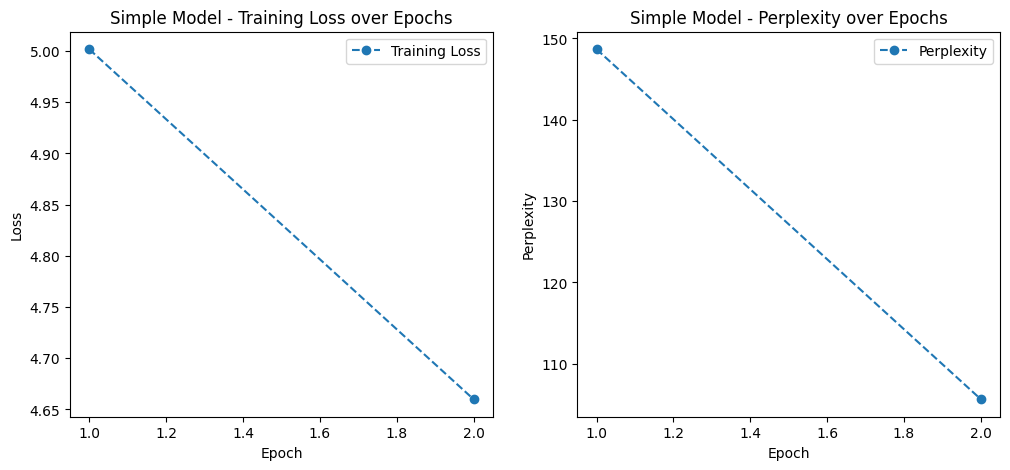

In [ ]:
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, label='Training Loss', linestyle='dashed', marker="o")
plt.title('Simple Model - Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities, label='Perplexity', linestyle='dashed', marker="o")
plt.title('Simple Model - Perplexity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

In [ ]:
model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_simple = math.exp(avg_loss)
print(f"Perplexity of base model: {perplexity_simple:.2f}")

Perplexity of base model: 89.29


In [ ]:
print(avg_loss)
print(total_loss)

0.14992265640758254
2529.04529093951


## generating text

In [ ]:
def generate_text(model, tokenizer, start_text, context_length=15, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat([context, next_token_id.unsqueeze(0)], dim=1)

    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=20)
print("Generated Text:\n")
print(generated_text)

Generated Text:

[CLS] من در راه[SEP] نگهداری میشود و در حال حاضر بیش از اعلام بودن نام در نتیجه برسیم.


؟؟؟ من در راه ؟؟؟ نگهداری میشود و در حال حاضر بیش از اعلام بودن نام در نتیجه برسیم

# cnn model

In [ ]:
class ConvolutionalLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, num_heads=4, num_layers=2, dropout=0.2):
        super(ConvolutionalLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)

        # Convolutional block
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=5, padding=2)
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        self.relu = nn.ReLU()

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)

        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)

        # Convolutional processing
        embeddings = embeddings.transpose(1, 2)  # Convert to [batch_size, embedding_dim, seq_len]
        embeddings = self.conv1(embeddings)
        embeddings = self.relu(self.batch_norm(embeddings))
        embeddings = self.conv2(embeddings)
        embeddings = embeddings.transpose(1, 2)  # Convert back to [batch_size, seq_len, embedding_dim]

        # Transformer processing
        embeddings = self.layer_norm(embeddings)
        transformer_output = self.transformer(embeddings)
        logits = self.linear(transformer_output)
        return logits

## setting up and training cnn model

In [ ]:
# Initialize the model
model = ConvolutionalLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 2

In [ ]:
train_losses = []
perplexities = []

# Go through learning epochs
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    # Read in data in batches
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Apply the forward pass
        logits = model(x)

        # Reshape logits and labels
        token_logits = logits.view(-1, vocab_size)
        token_labels = y.view(-1)

        # To understand what is happening during reshaping, print out logits.shape and token_logits.shape
        # and the same for y
        # print(logits.shape, token_logits.shape)
        # print(y.shape, token_labels.shape)
        # print(y[0])
        # print(token_labels[0:10])

        # Calculate the loss
        loss = criterion(token_logits,token_labels)

        # Apply the backward step (calculate the gradients)
        loss.backward()

        # Adjust the weights
        optimizer.step()

        # Accumulate the loss over batches
        total_loss += loss.item()

        # Monitor progress every twenty batches
        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average cross-entropy loss and perplexity
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)

    # Monitor developments over learning process
    train_losses.append(avg_loss)
    perplexities.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Epoch [1/2], Step [0/16869], Loss: 10.4468
Epoch [1/2], Step [20/16869], Loss: 7.0463
Epoch [1/2], Step [40/16869], Loss: 5.3469
Epoch [1/2], Step [60/16869], Loss: 4.4832
Epoch [1/2], Step [80/16869], Loss: 3.9462
Epoch [1/2], Step [100/16869], Loss: 3.5298
Epoch [1/2], Step [120/16869], Loss: 3.1291
Epoch [1/2], Step [140/16869], Loss: 2.9753
Epoch [1/2], Step [160/16869], Loss: 2.5834
Epoch [1/2], Step [180/16869], Loss: 2.3177
Epoch [1/2], Step [200/16869], Loss: 1.9112
Epoch [1/2], Step [220/16869], Loss: 1.8109
Epoch [1/2], Step [240/16869], Loss: 1.6709
Epoch [1/2], Step [260/16869], Loss: 1.4575
Epoch [1/2], Step [280/16869], Loss: 1.4356
Epoch [1/2], Step [300/16869], Loss: 1.3383
Epoch [1/2], Step [320/16869], Loss: 1.2711
Epoch [1/2], Step [340/16869], Loss: 1.0968
Epoch [1/2], Step [360/16869], Loss: 1.0016
Epoch [1/2], Step [380/16869], Loss: 1.0869
Epoch [1/2], Step [400/16869], Loss: 0.9464
Epoch [1/2], Step [420/16869], Loss: 0.9248
Epoch [1/2], Step [440/16869], Loss: 

## plot + loss and perplexity (cnn model)

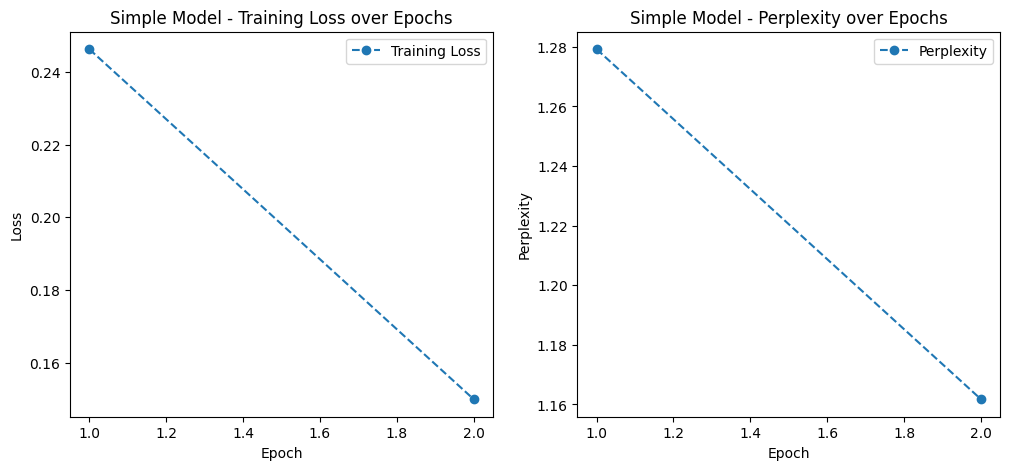

Perplexity of base model: 1.16
0.14410588694506624
303.7752096801996


In [ ]:
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, label='Training Loss', linestyle='dashed', marker="o")
plt.title('Simple Model - Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities, label='Perplexity', linestyle='dashed', marker="o")
plt.title('Simple Model - Perplexity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_simple = math.exp(avg_loss)
print(f"Perplexity of base model: {perplexity_simple:.2f}")
print(avg_loss)
print(total_loss)

## generating text (cnn model)

In [ ]:
def generate_text(model, tokenizer, start_text, context_length=15, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat([context, next_token_id.unsqueeze(0)], dim=1)
            # print(f"next_token_logits: {next_token_logits}, probabilities: {probabilities}, next_token_id: {next_token_id}, context: {context}")


    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=20)
print("Generated Text:\n")
print(generated_text)

Generated Text:

[CLS] من در راه[SEP] برگزار شد. 60136 شایان ذکر است، اما از


؟؟؟ من در راه ؟؟؟ برگزار شد. 60136 شایان ذکر است، اما از

# a pretrained model from hugging face

In [ ]:
from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('bolbolzaban/gpt2-persian')
generator = pipeline('text-generation', model, tokenizer=tokenizer, config={'max_length':512}, device='cuda')
sample = generator('در یک اتفاق شگفت انگیز، پژوهشگران')
sample

[{'generated_text': 'در یک اتفاق شگفت انگیز، پژوهشگران به گزارش گروه استان\u200cهای باشگاه خبرنگاران جوان از آبادان ؛ علی رضا داهیم بازیکن و مربی سابق تیم فوتبال وردربرمن با توجه به اینکه از کشور آلمان به کشور ما منتقل شده است'}]

model.safetensors:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

# running the reg model on pre-processed text

In [33]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 128
context_length = 32  # Context size for training
# vocab_size = tokenizer.n_vocab
vocab_size = 30000
embedding_dim = 128

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    formatted_text[:9999297], batch_size=batch_size,
    context_length=context_length, shuffle=True
)

# Initialize the model
model = RegularizedLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 2

train_losses = []
perplexities = []

# Go through learning epochs
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    # Read in data in batches
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Apply the forward pass
        logits = model(x)

        # Reshape logits and labels
        token_logits = logits.view(-1, vocab_size)
        token_labels = y.view(-1)

        # To understand what is happening during reshaping, print out logits.shape and token_logits.shape
        # and the same for y
        # print(logits.shape, token_logits.shape)
        # print(y.shape, token_labels.shape)
        # print(y[0])
        # print(token_labels[0:10])

        # Calculate the loss
        loss = criterion(token_logits,token_labels)

        # Apply the backward step (calculate the gradients)
        loss.backward()

        # Adjust the weights
        optimizer.step()

        # Accumulate the loss over batches
        total_loss += loss.item()

        # Monitor progress every twenty batches
        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average cross-entropy loss and perplexity
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)

    # Monitor developments over learning process
    train_losses.append(avg_loss)
    perplexities.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Using device: cuda
Epoch [1/2], Step [0/16076], Loss: 10.6828
Epoch [1/2], Step [20/16076], Loss: 10.0013
Epoch [1/2], Step [40/16076], Loss: 9.3403
Epoch [1/2], Step [60/16076], Loss: 8.7035
Epoch [1/2], Step [80/16076], Loss: 8.1264
Epoch [1/2], Step [100/16076], Loss: 7.5136
Epoch [1/2], Step [120/16076], Loss: 7.0860
Epoch [1/2], Step [140/16076], Loss: 6.8481
Epoch [1/2], Step [160/16076], Loss: 6.7364
Epoch [1/2], Step [180/16076], Loss: 6.5502
Epoch [1/2], Step [200/16076], Loss: 6.3960
Epoch [1/2], Step [220/16076], Loss: 6.3340
Epoch [1/2], Step [240/16076], Loss: 6.3052
Epoch [1/2], Step [260/16076], Loss: 6.2252
Epoch [1/2], Step [280/16076], Loss: 6.1702
Epoch [1/2], Step [300/16076], Loss: 6.1685
Epoch [1/2], Step [320/16076], Loss: 6.0959
Epoch [1/2], Step [340/16076], Loss: 6.0323
Epoch [1/2], Step [360/16076], Loss: 6.0098
Epoch [1/2], Step [380/16076], Loss: 6.0717
Epoch [1/2], Step [400/16076], Loss: 6.0274
Epoch [1/2], Step [420/16076], Loss: 5.9745
Epoch [1/2], Step

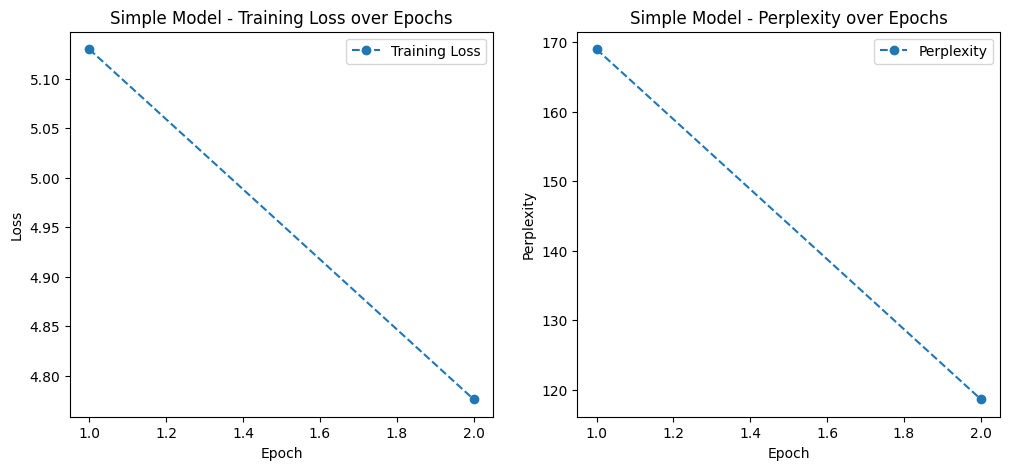

Perplexity of base model: 99.54
4.600590808169648
9242.586933612823


In [35]:
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, label='Training Loss', linestyle='dashed', marker="o")
plt.title('Simple Model - Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities, label='Perplexity', linestyle='dashed', marker="o")
plt.title('Simple Model - Perplexity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_simple = math.exp(avg_loss)
print(f"Perplexity of base model: {perplexity_simple:.2f}")
print(avg_loss)
print(total_loss)

In [36]:
def generate_text(model, tokenizer, start_text, context_length=15, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat([context, next_token_id.unsqueeze(0)], dim=1)
            # print(f"next_token_logits: {next_token_logits}, probabilities: {probabilities}, next_token_id: {next_token_id}, context: {context}")


    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
token_ids = tokenizer.encode(formatted_text)

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=20)
print("Generated Text:\n")
print(generated_text)

Generated Text:

[CLS] من در راه[SEP] هستند که می کردند 54 این بیمار کووید۱۶ روستا تو


؟؟؟  من در راه ؟؟؟  هستند که می کردند 54 این بیمار کووید۱۶ روستا تو

# transformer

In [16]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, hidden_dim=256, dropout=0.2):
        super(LanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        # Adding feedforward layers and non-linear activation functions
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)

        embeddings = token_embeds + position_embeds
        dropout_layer = self.dropout(embeddings)

        # Apply the feedforward layers
        first_layer = self.fc1(dropout_layer)
        non_linearity = self.relu(first_layer)
        # Second layer
        logits = self.fc2(non_linearity)
        return logits

In [17]:
class CausalSelfAttention(nn.Module):
    def __init__(self, embedding_dim, attention_dim, context_length):
        super(CausalSelfAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.attention_dim = attention_dim
        self.W_q = nn.Linear(embedding_dim, attention_dim)
        self.W_k = nn.Linear(embedding_dim, attention_dim)
        self.W_v = nn.Linear(embedding_dim, attention_dim)


        # Register a buffer for the causal mask
        self.register_buffer(  'mask',torch.tril(torch.ones(context_length, context_length)).unsqueeze(0))

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)


        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.attention_dim)

        # Apply the causal mask
        mask = self.mask[:, :seq_length, :seq_length]
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        return context, attention_weights

In [18]:
class MultiHeadCausalAttention(nn.Module):
    def __init__(self, embedding_dim, attention_dim, num_heads, context_length, dropout=0.1):
        super(MultiHeadCausalAttention, self).__init__()
        assert attention_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = attention_dim // num_heads

        self.embedding_dim = embedding_dim
        self.attention_dim = attention_dim
        self.W_q = nn.Linear(embedding_dim, attention_dim)
        self.W_k = nn.Linear(embedding_dim, attention_dim)
        self.W_v = nn.Linear(embedding_dim, attention_dim)
        self.fc_out = nn.Linear(attention_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer( 'mask',torch.tril(torch.ones(context_length, context_length)).unsqueeze(0))

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Split the embedding into self.num_heads different pieces
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim)

        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        #print("Q,K,V: ", Q.shape, K.shape, V.shape)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        #print("scores: ", scores.shape)
        # Apply the causal mask
        mask = self.mask[:, :seq_length, :seq_length]
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        #print("attention weights, values: ", attention_weights.shape, V.shape)
        context = torch.matmul(attention_weights, V)
        #print("context: ", context.shape)
        context = context.transpose(1, 2).contiguous()
        #print("context after transpose: ", context.shape)
        context = context.view(batch_size, seq_length, self.attention_dim)


        out = self.fc_out(context)
        return out, attention_weights

In [19]:
class LanguageModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, attention_dim, context_length, hidden_dim=256, num_heads=8, dropout=0.2):
        super(LanguageModelWithAttention, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.attention = MultiHeadCausalAttention(embedding_dim, attention_dim, num_heads, context_length, dropout)

        # Adding more layers and non-linear activation functions
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)

        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)

        # Apply the attention layer
        context, attention_weights = self.attention(embeddings)

        # Apply the feedforward layers
        out = self.fc1(context)
        out = self.relu(out)
        logits = self.fc2(out)
        return logits, attention_weights

In [20]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 32
context_length = 32  # Increased context size
# vocab_size = tokenizer.n_vocab
vocab_size = len(tokenizer)
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text[:9999297], batch_size=batch_size,
    context_length=context_length, shuffle=True
)

# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters'
num_epochs = 2

Using device: cuda


In [25]:
train_losses_attention = []
perplexities_attention = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x)
        
        # Reshape logits and targets for loss computation
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step "
                  f"[{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)
    train_losses_attention.append(avg_loss)
    perplexities_attention.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Epoch [1/2], Step [0/67476], Loss: 4.8641
Epoch [1/2], Step [10/67476], Loss: 4.4229
Epoch [1/2], Step [20/67476], Loss: 4.7749
Epoch [1/2], Step [30/67476], Loss: 4.6650
Epoch [1/2], Step [40/67476], Loss: 4.7652
Epoch [1/2], Step [50/67476], Loss: 4.4543
Epoch [1/2], Step [60/67476], Loss: 4.7768
Epoch [1/2], Step [70/67476], Loss: 4.7679
Epoch [1/2], Step [80/67476], Loss: 4.7035
Epoch [1/2], Step [90/67476], Loss: 4.3886
Epoch [1/2], Step [100/67476], Loss: 4.7196
Epoch [1/2], Step [110/67476], Loss: 4.7399
Epoch [1/2], Step [120/67476], Loss: 4.5634
Epoch [1/2], Step [130/67476], Loss: 4.7028
Epoch [1/2], Step [140/67476], Loss: 4.5428
Epoch [1/2], Step [150/67476], Loss: 4.5316
Epoch [1/2], Step [160/67476], Loss: 4.7211
Epoch [1/2], Step [170/67476], Loss: 4.6018
Epoch [1/2], Step [180/67476], Loss: 4.8427
Epoch [1/2], Step [190/67476], Loss: 4.6155
Epoch [1/2], Step [200/67476], Loss: 4.6325
Epoch [1/2], Step [210/67476], Loss: 4.8043
Epoch [1/2], Step [220/67476], Loss: 4.4829

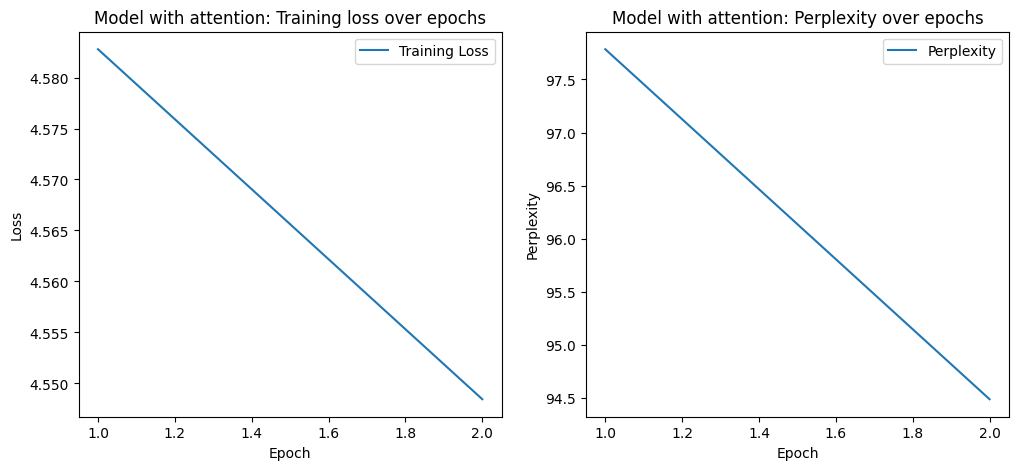

Perplexity for the model with attention: 74.47


In [26]:
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses_attention, label='Training Loss')
plt.title('Model with attention: Training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities_attention, label='Perplexity')
plt.title('Model with attention: Perplexity over epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_attention = math.exp(avg_loss)
print(f"Perplexity for the model with attention: {perplexity_attention:.2f}")

In [28]:
def generate_text(model, tokenizer, start_text, context_length=32, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long,
                          device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits, _ = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat(
                [context, next_token_id.unsqueeze(0)], dim=1
            )
    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=32)
print("Generated Text:\n")
print(generated_text)

Generated Text:

[CLS] من در راه[SEP] هوهمی نوشتوگویی پیشگاه ، الحشد و سپس با کار کارگردان «سیدجواد یعقوبی با اعلام شد و به اودرآورند


؟؟؟  من در راه ؟؟؟ هوهمی نوشتوگویی پیشگاه ، الحشد و سپس با کار کارگردان «سیدجواد یعقوبی با اعلام شد و به اودرآورند

# transformer with pre-processed text

Using device: cuda
Epoch [1/2], Step [0/64305], Loss: 10.1387
Epoch [1/2], Step [10/64305], Loss: 9.9929
Epoch [1/2], Step [20/64305], Loss: 8.8446
Epoch [1/2], Step [30/64305], Loss: 7.5650
Epoch [1/2], Step [40/64305], Loss: 7.1424
Epoch [1/2], Step [50/64305], Loss: 7.2266
Epoch [1/2], Step [60/64305], Loss: 7.0328
Epoch [1/2], Step [70/64305], Loss: 6.7566
Epoch [1/2], Step [80/64305], Loss: 6.7321
Epoch [1/2], Step [90/64305], Loss: 6.7959
Epoch [1/2], Step [100/64305], Loss: 6.9179
Epoch [1/2], Step [110/64305], Loss: 6.8096
Epoch [1/2], Step [120/64305], Loss: 6.6753
Epoch [1/2], Step [130/64305], Loss: 6.7246
Epoch [1/2], Step [140/64305], Loss: 6.6534
Epoch [1/2], Step [150/64305], Loss: 6.6062
Epoch [1/2], Step [160/64305], Loss: 6.6395
Epoch [1/2], Step [170/64305], Loss: 6.7370
Epoch [1/2], Step [180/64305], Loss: 6.5364
Epoch [1/2], Step [190/64305], Loss: 6.6499
Epoch [1/2], Step [200/64305], Loss: 6.4982
Epoch [1/2], Step [210/64305], Loss: 6.5006
Epoch [1/2], Step [220/

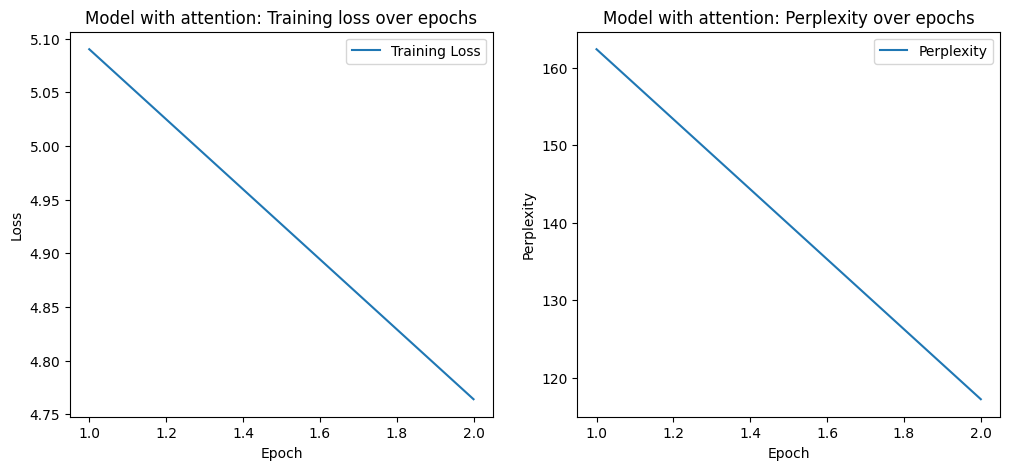

Perplexity for the model with attention: 89.81


In [29]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 32
context_length = 32  # Increased context size
# vocab_size = tokenizer.n_vocab
vocab_size = len(tokenizer)
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    formatted_text[:9999297], batch_size=batch_size,
    context_length=context_length, shuffle=True
)

# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters'
num_epochs = 2

train_losses_attention = []
perplexities_attention = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x)
        
        # Reshape logits and targets for loss computation
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step "
                  f"[{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)
    train_losses_attention.append(avg_loss)
    perplexities_attention.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

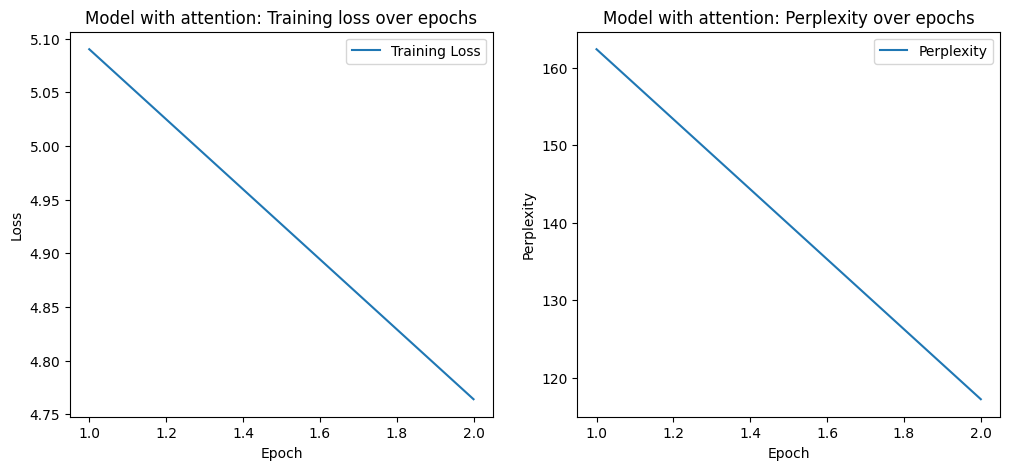

Perplexity for the model with attention: 89.81
4.497745903370599
36152.88157129288


In [32]:
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses_attention, label='Training Loss')
plt.title('Model with attention: Training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities_attention, label='Perplexity')
plt.title('Model with attention: Perplexity over epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_attention = math.exp(avg_loss)
print(f"Perplexity for the model with attention: {perplexity_attention:.2f}")
print(avg_loss)
print(total_loss)

In [30]:
def generate_text(model, tokenizer, start_text, context_length=32, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long,
                          device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits, _ = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat(
                [context, next_token_id.unsqueeze(0)], dim=1
            )
    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text
    
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
token_ids = tokenizer.encode(formatted_text)

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=32)
print("Generated Text:\n")
print(generated_text)

Generated Text:

[CLS] من در راه[SEP] اتفاق بیافتد و نیست جای حرکتکاران راه و اعلام کرد و پیش رو واگذار شده است 57184 حتی خوشبختانه آسمان


؟؟؟  من در راه ؟؟؟ اتفاق بیافتد و نیست جای حرکتکاران راه و اعلام کرد و پیش رو واگذار شده است 57184 حتی خوشبختانه آسمان

# add instead of concat

In [66]:
class MultiHeadCausalAttention(nn.Module):
    def __init__(self, embedding_dim, attention_dim, num_heads, context_length, dropout=0.1):
        super(MultiHeadCausalAttention, self).__init__()
        assert attention_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = attention_dim // num_heads

        self.embedding_dim = embedding_dim
        self.attention_dim = attention_dim
        self.W_q = nn.Linear(embedding_dim, attention_dim)
        self.W_k = nn.Linear(embedding_dim, attention_dim)
        self.W_v = nn.Linear(embedding_dim, attention_dim)
        self.fc_out = nn.Linear(attention_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer( 'mask',torch.tril(torch.ones(context_length, context_length)).unsqueeze(0))

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Split the embedding into self.num_heads different pieces
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim)

        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        #print("Q,K,V: ", Q.shape, K.shape, V.shape)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        #print("scores: ", scores.shape)
        # Apply the causal mask
        mask = self.mask[:, :seq_length, :seq_length]
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        #print("attention weights, values: ", attention_weights.shape, V.shape)
        context = torch.matmul(attention_weights, V)
        #print("context: ", context.shape)

        context = context.sum(dim=1)
        context = context.repeat_interleave(self.num_heads, dim=-1)

        out = self.fc_out(context)
        return out, attention_weights


In [67]:
class LanguageModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, attention_dim, context_length, hidden_dim=256, num_heads=8, dropout=0.2):
        super(LanguageModelWithAttention, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.attention = MultiHeadCausalAttention(embedding_dim, attention_dim, num_heads, context_length, dropout)

        # Adding more layers and non-linear activation functions
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)

        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)

        # Apply the attention layer
        context, attention_weights = self.attention(embeddings)

        # Apply the feedforward layers
        out = self.fc1(context)
        out = self.relu(out)
        logits = self.fc2(out)
        return logits, attention_weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 32
context_length = 32  # Increased context size
# vocab_size = tokenizer.n_vocab
vocab_size = len(tokenizer)
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    formatted_text[:9999297], batch_size=batch_size,
    context_length=context_length, shuffle=True
)

# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters'
num_epochs = 2

train_losses_attention = []
perplexities_attention = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logits, _ = model(x)
        
        # Reshape logits and targets for loss computation
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step "
                  f"[{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)
    train_losses_attention.append(avg_loss)
    perplexities_attention.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Using device: cuda
Epoch [1/2], Step [0/64305], Loss: 10.1423
Epoch [1/2], Step [10/64305], Loss: 9.7549
Epoch [1/2], Step [20/64305], Loss: 8.3209
Epoch [1/2], Step [30/64305], Loss: 7.4312
Epoch [1/2], Step [40/64305], Loss: 7.2445
Epoch [1/2], Step [50/64305], Loss: 7.2170
Epoch [1/2], Step [60/64305], Loss: 6.8157
Epoch [1/2], Step [70/64305], Loss: 7.0283
Epoch [1/2], Step [80/64305], Loss: 7.0572
Epoch [1/2], Step [90/64305], Loss: 6.8303
Epoch [1/2], Step [100/64305], Loss: 6.8476
Epoch [1/2], Step [110/64305], Loss: 6.7023
Epoch [1/2], Step [120/64305], Loss: 6.8422
Epoch [1/2], Step [130/64305], Loss: 6.7851
Epoch [1/2], Step [140/64305], Loss: 6.8684
Epoch [1/2], Step [150/64305], Loss: 6.6249
Epoch [1/2], Step [160/64305], Loss: 6.6894
Epoch [1/2], Step [170/64305], Loss: 6.4854
Epoch [1/2], Step [180/64305], Loss: 6.7716
Epoch [1/2], Step [190/64305], Loss: 6.6230
Epoch [1/2], Step [200/64305], Loss: 6.4857
Epoch [1/2], Step [210/64305], Loss: 6.5177
Epoch [1/2], Step [220/

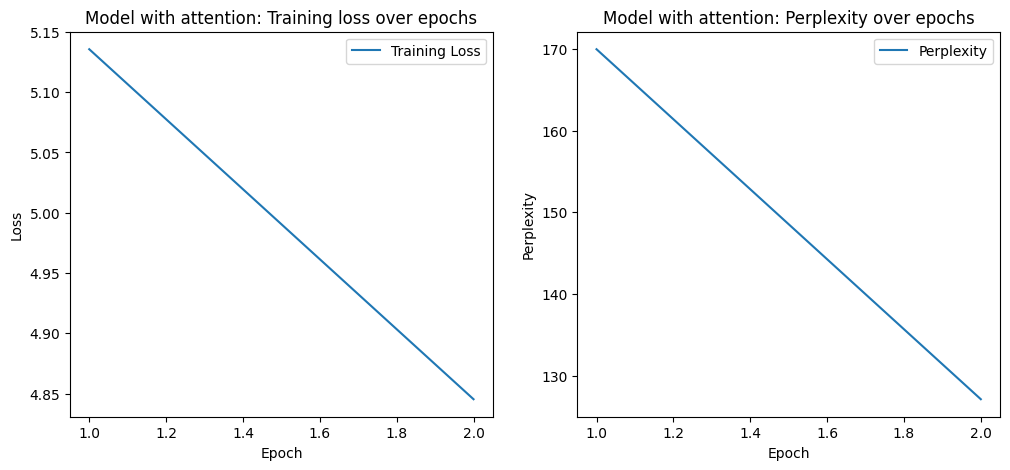

Perplexity for the model with attention: 101.05
4.615642619981313
37100.53537940979


In [68]:
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses_attention, label='Training Loss')
plt.title('Model with attention: Training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities_attention, label='Perplexity')
plt.title('Model with attention: Perplexity over epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_attention = math.exp(avg_loss)
print(f"Perplexity for the model with attention: {perplexity_attention:.2f}")
print(avg_loss)
print(total_loss)

In [69]:
def generate_text(model, tokenizer, start_text, context_length=32, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long,
                          device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits, _ = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat(
                [context, next_token_id.unsqueeze(0)], dim=1
            )
    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text
    
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
token_ids = tokenizer.encode(formatted_text)

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=32)
print("Generated Text:\n")
print(generated_text)

Generated Text:

[CLS] من در راه[SEP] طبیعی می داشت که دو برنامه تا در دقایق اولیه آلودهکاری های اساسی را اقدام کنند 70243 ما هدف یک


؟؟  من در راه ؟؟ طبیعی می داشت که دو برنامه تا در دقایق اولیه آلودهکاری های اساسی را اقدام کنند 70243